## Introduction

**VAEs** can be used for generative purposes. 
This code demonstrates VAE using USPS Digit dataset.
Just like regular autoencoder VAE returns an array (image) of same domensions
as input but we can introduce variation by tweaking the latent vector. The entire model is implemented in TensorFlow and used extra_keras_datasets module to load our USPS Dataset.

## What is Variational AutoEncoder?
 VAE is an autoencoder whose encodings distribution is regularised during the training in order to ensure that its latent space has good properties allowing us to generate some new data. A variational autoencoder (VAE) provides a probabilistic manner for describing an observation in latent space.
![VAE](https://miro.medium.com/max/3080/1*82EghOQR2Z5uuwUjFiVV2A.png) 

Source -  [The Intuition Behind Variational Autoencoders](https://medium.com/@realityenginesai/understanding-variational-autoencoders-and-their-applications-81a4f99efc0d), [Variational autoencoders.](https://www.jeremyjordan.me/variational-autoencoders/)

In [1]:
!pip install extra_keras_datasets

In [2]:
from extra_keras_datasets import usps
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
import keras
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.layers import BatchNormalization
from keras.models import Model
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
from sklearn.decomposition import PCA
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


In [3]:
# Configuration options
batch_size = 64
no_epochs = 50
validation_split_size = 0.2


## Loading the dataset
Now that we have specified the configuration options, it’s time to load the dataset. Fortunately, with the [Extra Keras Datasets package](https://www.machinecurve.com/index.php/2020/01/10/making-more-datasets-available-for-keras/), this is really easy:

In [4]:
# Load dataset
(x_train, y_train), (x_test, y_test) = usps.load_data()

INFO:root:Loading dataset = usps


Check image shape

In [5]:
x_train.shape

(7291, 16, 16)

Next, we have to do three things:

* Scale the data to the [0,1] range, which helps the optimization process.

* Reshape the 2D grayscale data (which has dimensions for width and height only) into a 3D object, because the Conv2D accepts arrays with 3D inputs (width, height and color channels only). 


In [6]:
#Normalize and reshape ============

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = (x_train-x_train.min())/(x_train.max()-x_train.min())
x_test = (x_test-x_test.min())/(x_test.max()-x_test.min())

#Reshape 
img_width  = x_train.shape[1]
img_height = x_train.shape[2]
num_channels = 1 #USPS --> grey scale so 1 channel
x_train = x_train.reshape(x_train.shape[0], img_height, img_width, num_channels)
x_test = x_test.reshape(x_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

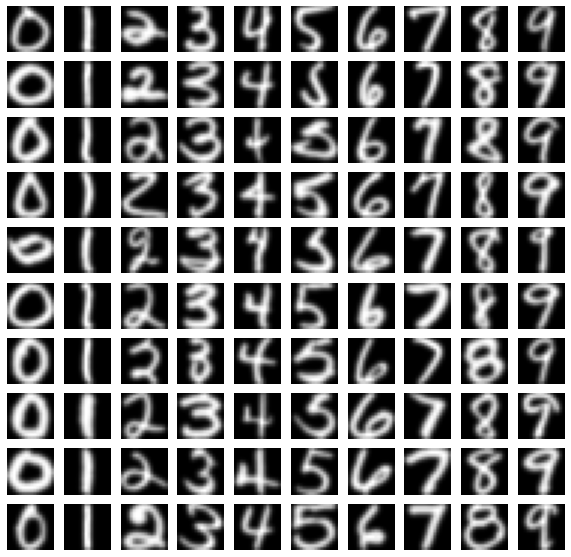

In [7]:
#View a few images
num_samples = 10
num_classes = len(set(y_train))

fig, ax = plt.subplots(num_samples, num_classes, sharex = True, sharey = True, figsize=(num_classes, num_samples))

for label in range(num_classes):
    class_idxs = np.where(y_train == label)
    
    for i, idx in enumerate(np.random.randint(0, class_idxs[0].shape[0], num_samples)):
        ax[i, label].imshow(x_train[class_idxs[0][idx]].reshape([16, 16]), 'gray')
        ax[i, label].set_axis_off()





## Encoder network
This defines the approximate posterior distribution *q(z|x)*, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation *z*. In this example, we simply model the distribution as a diagonal Gaussian, and the network outputs the mean and log-variance parameters of a factorized Gaussian. We output log-variance instead of the variance directly for numerical stability.
## Decoder network
This defines the conditional distribution of the observation *p(x|z)*, which takes a latent sample *z* as input and outputs the parameters for a conditional distribution of the observation. We model the latent distribution prior *p(z)* as a unit Gaussian.
## Reparameterization
To generate a sample *z* for the decoder during training, we can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation *x*. However, this sampling operation creates a bottleneck because backpropagation cannot flow through a random node.

To address this, we use a reparameterization trick. In our example, we approximate *z* using the decoder parameters and another parameter *ϵ* as follows:

z = μ + σ.ϵ

Source: [Tensorflow](https://www.tensorflow.org/tutorials/generative/cvae)


## Creating the model Architecture

We use 4 Convolutional layers for the encoder followed by a fully-connected layer. In the decoder network, mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts).


* Specifically note the input_shape = input_shape assignment in the first layer, telling Keras what the shape of an input sample looks like!

### Encoder part

In [8]:
latent_dim = 20

In [9]:
def encoder(input_shape):
    input_img = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
    x = BatchNormalization()(x)
    x = Conv2D(64, 3, padding='same', activation='relu',strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, 3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    
    conv_shape = K.int_shape(x) #Shape of conv to be provided to decoder
    # #Flatten
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)

    # Two outputs, for latent mean and log variance (std. dev.)
    #Use these to sample random variables in latent space to which inputs are mapped. 
    z_mu = Dense(latent_dim, name='latent_mu')(x)   #Mean values of encoded input
    z_sigma = Dense(latent_dim, name='latent_sigma')(x)  #Std dev. (variance) of encoded input
    
    return input_img, x, conv_shape, z_mu, z_sigma
    

In [10]:
input_img, x, conv_shape, z_mu, z_sigma = encoder(input_shape)

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


## REPARAMETERIZATION TRICK

* Define sampling function to sample from the distribution
* Reparameterize sample based on the process defined by Gunderson and Huang into the shape of: mu + sigma squared x eps
* This is to allow gradient descent to allow for gradient estimation accurately. 


In [11]:
def sample_z(args):
    z_mu, z_sigma = args
#     eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    eps = K.random_normal(shape=(K.shape(z_mu)[0], K.int_shape(z_mu)[1]))
    
    return z_mu + K.exp(z_sigma / 2) * eps

# sample vector from the latent distribution
# z is the lambda custom layer we are adding for gradient descent calculations
  # using mu and variance (sigma)
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

#Z (lambda layer) will be the last layer in the encoder.
# Define and summarize encoder model.
encoder = Model(input_img, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['batch_normalization[0][0]

### Decoder Part

In [12]:
def decoder(conv_shape):
    # decoder takes the latent vector as input
    decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
    # Need to start with a shape that can be remapped to original image shape as
    #we want our final utput to be same shape original input.
    #So, add dense layer with dimensions that can be reshaped to desired output shape
    x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
    x = BatchNormalization()(x)
    # reshape to the shape of last conv. layer in the encoder, so we can 
    x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
    # upscale (conv2D transpose) back to original shape
    # use Conv2DTranspose to reverse the conv layers defined in the encoder
    x = Conv2DTranspose(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
    x = BatchNormalization()(x)
    #Can add more conv2DTranspose layers, if desired. 
    #Using sigmoid activation
    x = Conv2DTranspose(num_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

    # Define and summarize decoder model
    decoder = Model(decoder_input, x, name='decoder')
    decoder.summary()
    # apply the decoder to the latent sample 
    z_decoded = decoder(z)
    
    return decoder, z_decoded

In [13]:
decoder, z_decoded = decoder(conv_shape) 

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 20)]              0         
                                                                 
 dense_1 (Dense)             (None, 4096)              86016     
                                                                 
 batch_normalization_5 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 32)       18464     
 nspose)                                                         
                                                                 
 batch_normalization_6 (Batc  (None, 16, 16, 32)       128 

Let's Define Our Custom Loss Function

In [14]:
# =========================
#Define custom loss
#VAE is trained using two loss functions reconstruction loss and KL divergence
#Let us add a class to define a custom layer with loss
class CustomLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_sigma - K.square(z_mu) - K.exp(z_sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomLayer()([input_img, z_decoded])
# y is basically the original image after encoding input img to mu, sigma, 
# and decoding sampled z values.
#This will be used as output for vae

# =================
# VAE 
# =================
vae = Model(input_img, y, name='vae')


## Compiling the model

We can now compile our model skeleton into a functional model. Since we already specified the configuration options before, this is really easy

In [15]:
# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['batch_normalization[0][0]']  

## Fitting data to the model


In [18]:
checkpointer = ModelCheckpoint(filepath='bestmodel.h5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)

# Train autoencoder
hist = vae.fit(x_train,
        None, 
        epochs = 50, 
        shuffle=False,
        batch_size = 150, 
        validation_split = 0.1,
        callbacks=[checkpointer, earlystopper])


Train on 6561 samples, validate on 730 samples
Epoch 1/50
6561/6561 [==============================] - ETA: 0s - loss: 0.6162

C:\Users\Glodaris\anaconda3\lib\site-packages\keras\engine\training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6561/6561 [==============================] - 6s 931us/sample - loss: 0.6162 - val_loss: 0.6086
Epoch 2/50
6561/6561 [==============================] - 4s 654us/sample - loss: 0.4008 - val_loss: 0.5693
Epoch 3/50
6561/6561 [==============================] - 5s 777us/sample - loss: 0.3536 - val_loss: 0.5619
Epoch 4/50
6561/6561 [==============================] - 6s 923us/sample - loss: 0.3404 - val_loss: 0.5457
Epoch 5/50
6561/6561 [==============================] - 5s 745us/sample - loss: 0.3336 - val_loss: 0.5231
Epoch 6/50
6561/6561 [==============================] - 5s 734us/sample - loss: 0.3292 - val_loss: 0.4980
Epoch 7/50
6561/6561 [==============================] - 5s 724us/sample - loss: 0.3262 - val_loss: 0.4673
Epoch 8/50
6561/6561 [==============================] - 5s 796us/sample - loss: 0.3240 - val_loss: 0.4396
Epoch 9/50
6561/6561 [==============================] - 5s 821us/sample - loss: 0.3224 - val_loss: 0.4105
Epoch 10/50
6561/6561 [==============================] - 

### Result

A. Clustering of digits in the latent space

We can make predictions on the validation set using the encoder network. This has the effect of translating the images from the 256-dimensional input space into the 2-dimensional latent space. When we color-code those translated data points according to their known digit class, we can see how the digits cluster together.

In [20]:
def latent_space(x_test):
    mu, sigma, z = encoder.predict(x_test)
    print(mu.shape)
    print(sigma)
    mean_distribution = [{i: mu[:, i].tolist()} for i in range(mu.shape[1])]
    array = dict()
    for index in range(len(mean_distribution)):
        array.update(mean_distribution[index])
    data = pd.DataFrame(array)
    data['classes'] = y_test.astype(int)
    columns = list(data.columns[:-1])
    ###Dimensionality reduction####
    pca = PCA(n_components=2)
    pca.fit(data[columns])
    transformed = pca.transform(data[columns])
    plt.figure(figsize=(10, 10))
    plt.scatter(transformed[:,0], transformed[:,1], c= y_test, cmap='brg')
    plt.title(f'Plot of Latent Distribution for a latent vector of {mu.shape[1]} ')
    plt.xlabel('dim 1')
    plt.ylabel('dim 2')
    plt.colorbar()
    plt.show()
    
    return data, sigma

C:\Users\Glodaris\anaconda3\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(2007, 20)
[[-5.5446196 -4.9496684 -5.649534  ... -5.2768083 -4.9356833 -6.237703 ]
 [-5.183733  -5.9357    -6.9100175 ... -5.4919105 -4.439202  -6.2541366]
 [-4.833726  -5.8976784 -4.4142375 ... -5.3103676 -4.9915333 -4.841092 ]
 ...
 [-5.318947  -6.1251435 -7.2140245 ... -6.2098203 -4.70801   -6.5192285]
 [-6.1557055 -5.9520783 -5.4876246 ... -6.269714  -5.866335  -6.4751997]
 [-3.9394944 -4.3780656 -4.002354  ... -3.5513523 -3.9045696 -4.584602 ]]


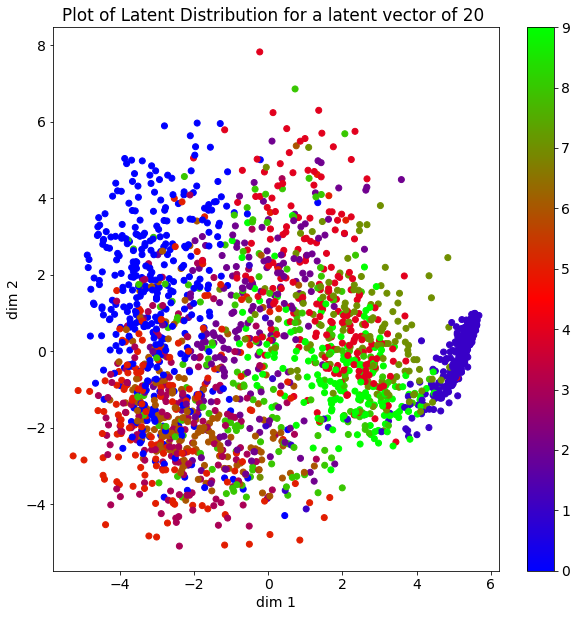

In [21]:
data, sigma = latent_space(x_test)

In [ ]:
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 10)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

def make_prediction(data, x_test):
    sample_vector = np.array(data).reshape(1,data.shape[0]) #np.array([[,-1,-1,1,1,1,1,1,1]])
    decoded_example = decoder.predict(sample_vector)
    decoded_example_reshaped = decoded_example.reshape(img_width, img_height)
    plt.subplot(221)
    plt.title('Generated image')
    plt.imshow(decoded_example_reshaped, cmap='gray')
    plt.subplot(222)
    plt.title('Real Image')
    plt.imshow(x_test[:,:,0], cmap='gray');
    
    
### Make Predictions using  the decoder network
make_prediction(data.iloc[50][:-1], x_test[50])
